In [1]:
# source: https://www.kaggle.com/datasets/martinellis/synthetic-lego-images/

import cv2
import torch
import numpy as np
import pandas as pd
import albumentations as A
from pathlib import Path
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch.transforms import ToTensorV2
from typing import Dict

device = torch.device('cuda')

DATA_ROOT: Path = Path('./datasets/synthetic-lego-images/versions/4/')
CLASSES_DATAFRAME_FILE: str = "classes.csv"
ANNOTATION_DATAFRAME_FILE: str = "annotation-data.csv"
SEMANTIC_SEGMENTATION_DIR: str = 'semantic-segmentation'

In [2]:
# class VOCDataset(Dataset):
#     _split: Dict[str, np.ndarray] | None = None
#     _annotations: pd.DataFrame | None

#     def __new__(cls, *args, **kwargs):
        
#         if cls._split is None:
#             cls._annotations = pd.read_csv(DATA_ROOT / ANNOTATION_DATAFRAME_FILE)
#             ann_ids_df = cls._annotations.drop_duplicates('img_id')

#             if 'frac' in kwargs:
#                 valid_ids_df = ann_ids_df.sample(frac=kwargs['frac'], replace=False)
#             elif 'n' in kwargs:
#                 valid_ids_df = ann_ids_df.sample(n=kwargs['n'], replace=False)
#             else:
#                 valid_ids_df = ann_ids_df.sample(n=100, replace=False)

#             valid_ids = valid_ids_df['img_id'].unique()
#             train_ids = ann_ids_df[ ~ann_ids_df['img_id'].isin(valid_ids) ]['img_id'].unique()
#             cls._split = {
#                 'train': train_ids,
#                 'valid': valid_ids
#             }
#         return super().__new__(cls)

#     def __init__(self,
#                  split: str,
#                  transforms: A.Compose | None = None,
#                  with_masks: bool = False):
        
#         super().__init__()

#         assert self._split is not None
#         assert self._annotations is not None

#         self.image_ids = self._split[split]
#         self.annotations = self._annotations

#         classes_df = pd.read_csv(DATA_ROOT / CLASSES_DATAFRAME_FILE)
#         self.classes = pd.Series(classes_df.name.astype(str),index=classes_df.label_id.astype(int)).to_dict()

#         self.transforms = transforms
#         self.with_masks = with_masks

#     def __getitem__(self, index: int | str):
#         image_id = self.image_ids[index] if isinstance(index, int) else index
#         records = self.annotations[self.annotations['img_id'] == image_id]

#         image_fn = DATA_ROOT / image_id
#         image = cv2.imread(str(image_fn), cv2.IMREAD_COLOR)
        
#         assert image is not None
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         mask_image = None
#         if self.with_masks:
#             masks_fn = image_fn.parent.parent / SEMANTIC_SEGMENTATION_DIR / image_id.split('/')[-1].replace('rgb', 'segmentation')
#             mask_image = cv2.imread(str(masks_fn), cv2.IMREAD_COLOR)

#             assert mask_image is not None
#             mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)

#         # mine are different, heithg & width not xmax & ymax
#         boxes = records[['x', 'y', 'w', 'h']].values
#         boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
#         boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         area = torch.as_tensor(area, dtype=torch.float32)

#         labels = records['labels'].values
#         # labels = torch.as_tensor(label, dtype=torch.int64)

#         # suppose all instances are not crowd
#         iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

#         target = {}
#         target['boxes'] = boxes
#         target['labels'] = labels
#         # target['masks'] = None
#         target['image_id'] = torch.as_tensor(records.index.min())
#         target['area'] = area
#         target['iscrowd'] = iscrowd

#         if not self.transforms:
#             # simply cast from uint to float
#             image = image.astype(torch.float32) / 255.0 #type:ignore
#             if mask_image is not None:
#                 mask_image = mask_image.astype(torch.float32) / 255.0 #type:ignore
#         else:
#             sample = {
#                 'image': image,
#                 'mask': mask_image,
#                 'bboxes': target['boxes'],
#                 'labels': labels
#             }
#             sample = self.transforms(**sample)
#             image = sample['image']
#             mask_image = sample['mask']

#             target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)

#         if not self.with_masks:
#             return image, target
        
#         return image, target, mask_image

#     def __len__(self) -> int:
#         return self.image_ids.shape[0]

# def get_transform_train():
#     return A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(p=0.2),
#         A.ToFloat(255.0, p=1.0),
#         ToTensorV2(transpose_mask=True, p=1.0)
#     ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

# def get_transform_valid():
#     return A.Compose([
#         A.ToFloat(255.0, p=1.0),
#         ToTensorV2(transpose_mask=True, p=1.0),
#     ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

from lib.lego_dataset import SynthentcLegoImagesDataset, get_transform_train, get_transform_valid

In [3]:
train_dataset = SynthentcLegoImagesDataset(DATA_ROOT, 'train', get_transform_train(), with_masks=True)
valid_dataset = SynthentcLegoImagesDataset(DATA_ROOT, 'valid', get_transform_valid(), with_masks=True)

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

x = train_dataset[0][-1]

/home/kol/kol/redbull/.venv/lib/python3.13/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


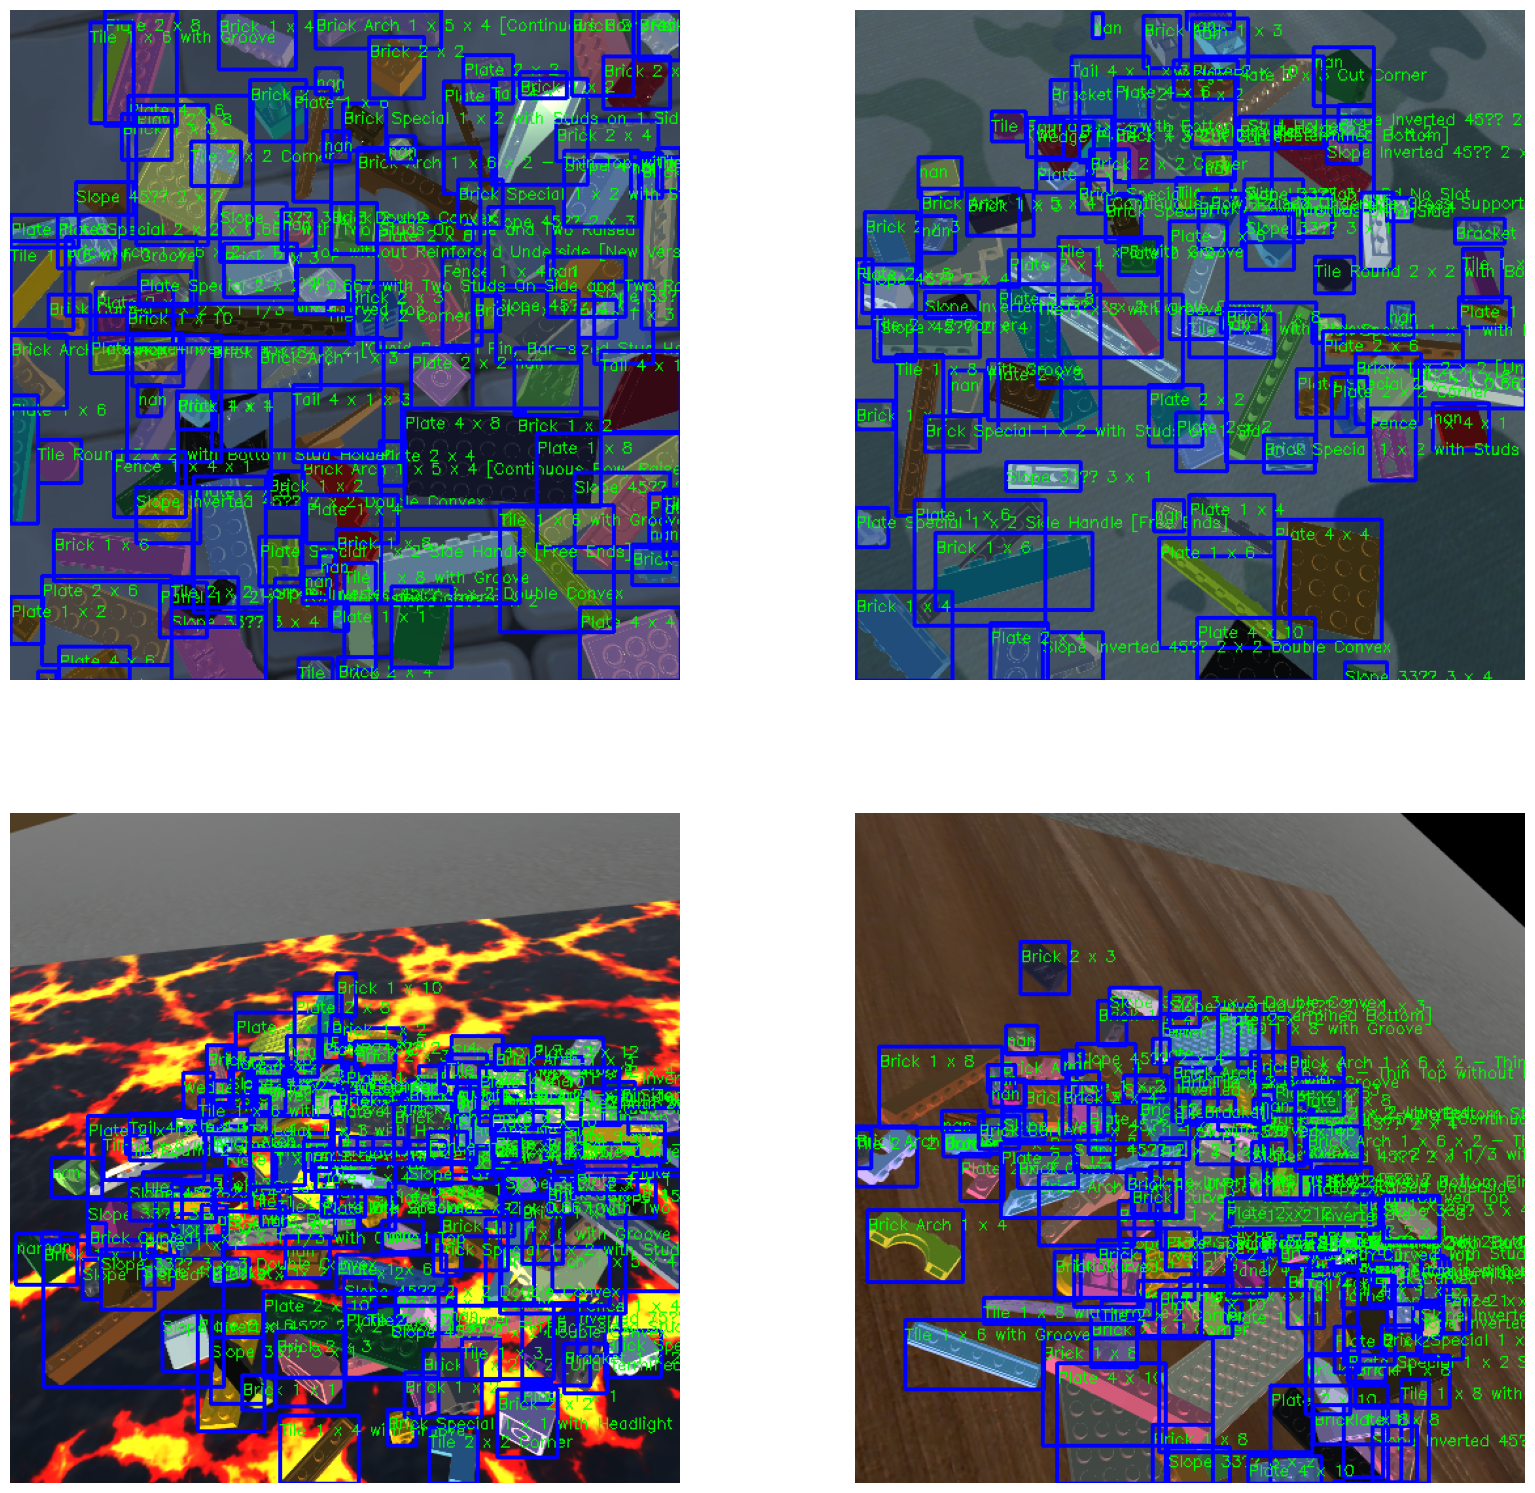

In [4]:
images, targets, masks = next(iter(valid_data_loader))

plt.figure(figsize=(20,40))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(4,2, i+1)
    boxes = target['boxes'].cpu().numpy().astype(np.int32)
    sample = image.permute(1,2,0).cpu().numpy()
    names = target['labels'].astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 1), 2)
        cv2.putText(sample, train_dataset.classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_SIMPLEX,0.4,(0,1,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)


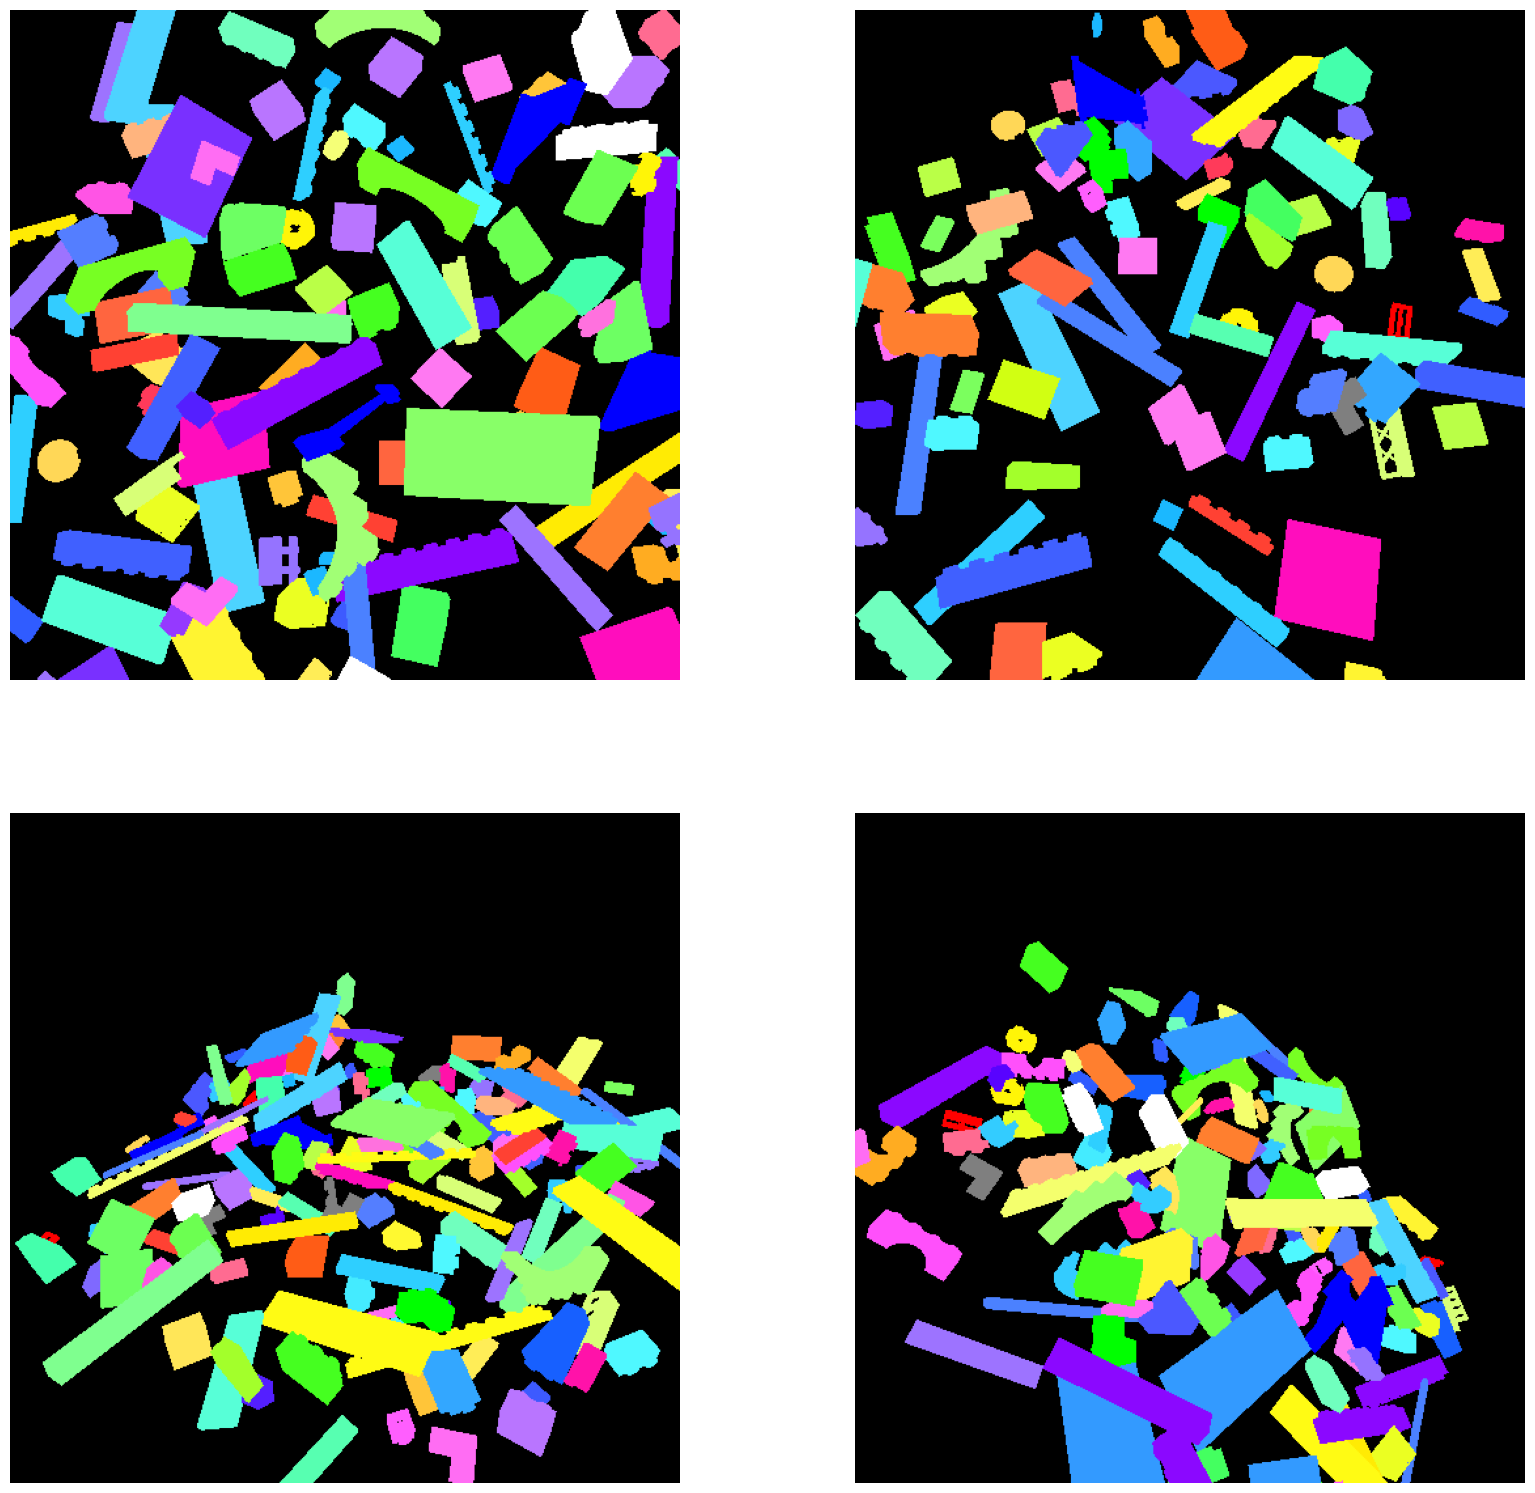

In [5]:

plt.figure(figsize=(20,40))
for i, (image, target, mask) in enumerate(zip(images, targets, masks)):
    plt.subplot(4,2, i+1)
    sample = np.array(mask).transpose(1,2,0)
    plt.axis('off')
    plt.imshow(sample)


In [6]:
# mask_reshaped = mask.permute(1, 2, 0).reshape(-1, 3)
# objects = torch.unique(mask_reshaped, dim=0)[1:]

# plt.figure(figsize=(20,20))
# for n, object_color in enumerate(objects):
#     plt.subplot(10, 10, n+1)
#     object_mask = (mask_reshaped == object_color)
#     object_mask = object_mask.all(dim=-1).reshape(mask.shape[1:])

#     empty = torch.zeros((mask.shape[1], mask.shape[2], mask.shape[0]), dtype=mask.dtype)
#     empty[object_mask, :] = object_color

#     plt.axis('off')
#     _ = plt.imshow(empty.cpu().numpy())

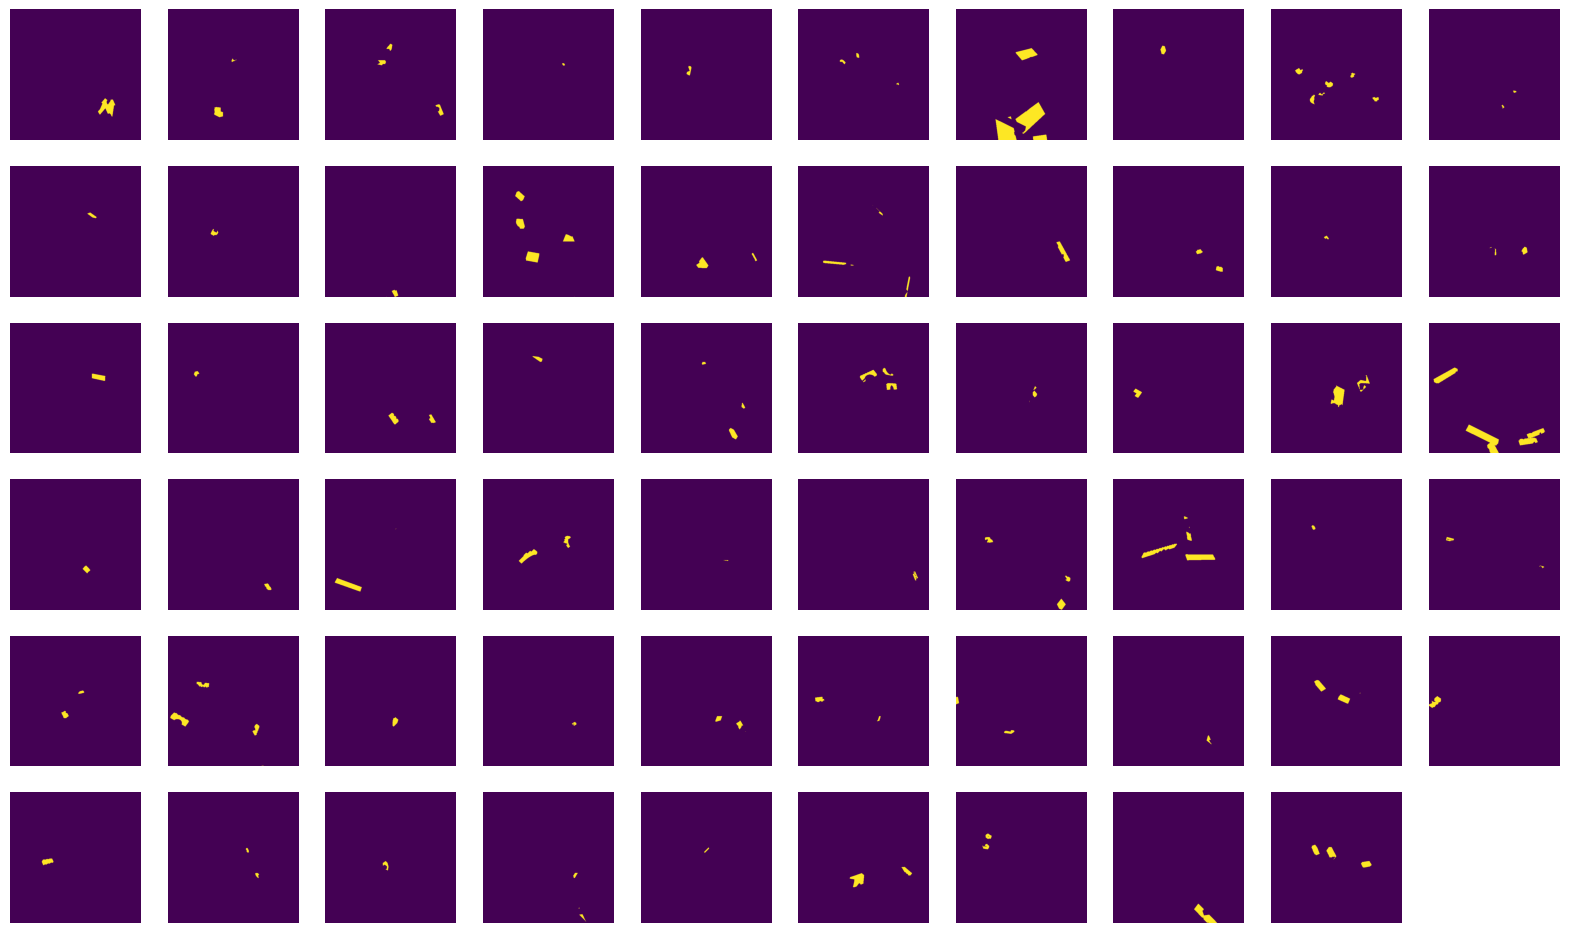

In [7]:
plt.figure(figsize=(20,20))
for n, m in enumerate(mask):
    plt.subplot(10, 10, n+1)
    plt.axis('off')
    _ = plt.imshow(m)